# Marketing A/B Testing

### About Dataset

[Marketing A/B testing dataset](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing)


Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

## Problem to Solve

The companies are interested in answering two questions:

- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be. 


## Goal

Analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant. 


# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from statsmodels.stats.power import NormalIndPower, TTestIndPower
from statsmodels.stats.proportion import confint_proportions_2indep

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("darkgrid")

## Load the Data

In [2]:
df = pd.read_csv("data/marketing_AB.csv", index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


# Dataset Overview

| Variable Name | Description  | 
|---:|:-------------|
| **Index** | Row index  |  
| **user id** | User ID (unique)  |
| **test group** | If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement  |
| **converted** | If a person bought the product then True, else is False  |
| **total ads** |  Amount of ads seen by person  |
| **most ads day** | Day that the person saw the biggest amount of ads |
| **most ads hour** | Hour of day that the person saw the biggest amount of ads  |


In [3]:
# Rename columns
df = df.rename(columns={
    'user id': 'user_id',
    'test group': 'test_group',
    'converted': 'converted',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
})

# Exploratory Data Analysis (EDA)

In [4]:
df1 = df.copy()
df1.shape

(588101, 6)

In [5]:
df1.isnull().sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

In [6]:
df1.duplicated().any()

False

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [8]:
# Unique values in categorical columns
print(f"Test Group: {df1["test_group"].unique()}")
print(f"Converted: {df1["converted"].unique()}")
print(f"Most Ads Day: {df1["most_ads_day"].unique()}")

Test Group: ['ad' 'psa']
Converted: [False  True]
Most Ads Day: ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']


In [9]:
# Descriptive statistics with skewness and kurtosis for numeric columns
num_cols = df1.select_dtypes(include=[np.number]).columns
descriptive_stats = df1[num_cols].describe().T
descriptive_stats['skewness'] = df1[num_cols].skew()
descriptive_stats['kurtosis'] = df1[num_cols].kurtosis()

print("\nDescriptive Statistics (including skewness and kurtosis):")
descriptive_stats


Descriptive Statistics (including skewness and kurtosis):


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
user_id,588101.0,1.310692e+06,202225.983128,900000.0,1143190.0,1313725.0,1484088.0,1654483.0,-0.100358,-1.043314
total_ads,588101.0,2.482088e+01,43.715181,1.0,4.0,13.0,27.0,2065.0,7.433113,109.917983
most_ads_hour,588101.0,1.446906e+01,4.834634,0.0,11.0,14.0,18.0,23.0,-0.336972,0.103237


- The `total_ads` variable is highly skewed and has a high kurtosis value, indicating that while most users have seen a low number of ads, there are more outliers. This could impact the analysis and should be considered during hypothesis testing. 
- The `most_ads_hour` variable ivariable shows a slight leftward skew with no notable outliers or heavy tails in its distribution.

In [10]:
# Group by test group and calculate summary statistics
summary_stats = df1.groupby("test_group").agg({
    "converted": ["sum", "mean"],  
    "total_ads": ["count", "mean", "min" ,"std", "median", "max"],  
    "most_ads_hour": ["count", "mean", "min" ,"std", "median", "max"]  
})

summary_stats

converted           total_ads                                   \
                 sum      mean     count       mean min        std median   
test_group                                                                  
ad             14423  0.025547    564577  24.823365   1  43.750456   13.0   
psa              420  0.017854     23524  24.761138   1  42.860720   12.0   

                 most_ads_hour                                      
             max         count       mean min       std median max  
test_group                                                          
ad          2065        564577  14.475900   0  4.841808   14.0  23  
psa          907         23524  14.304923   0  4.656239   14.0  23

In [11]:
# Cross-tabulation for test_group and converted
crosstab_converted = pd.crosstab(df1['test_group'], df1['converted'])
crosstab_converted 

converted,False,True
test_group,,
ad,550154,14423
psa,23104,420


In [12]:
df1.groupby(["test_group", "converted"]).converted.agg(["count", "min", "median", "mean", "std", "max"])

count    min  median  mean  std    max
test_group converted                                         
ad         False      550154  False     0.0   0.0  0.0  False
           True        14423   True     1.0   1.0  0.0   True
psa        False       23104  False     0.0   0.0  0.0  False
           True          420   True     1.0   1.0  0.0   True

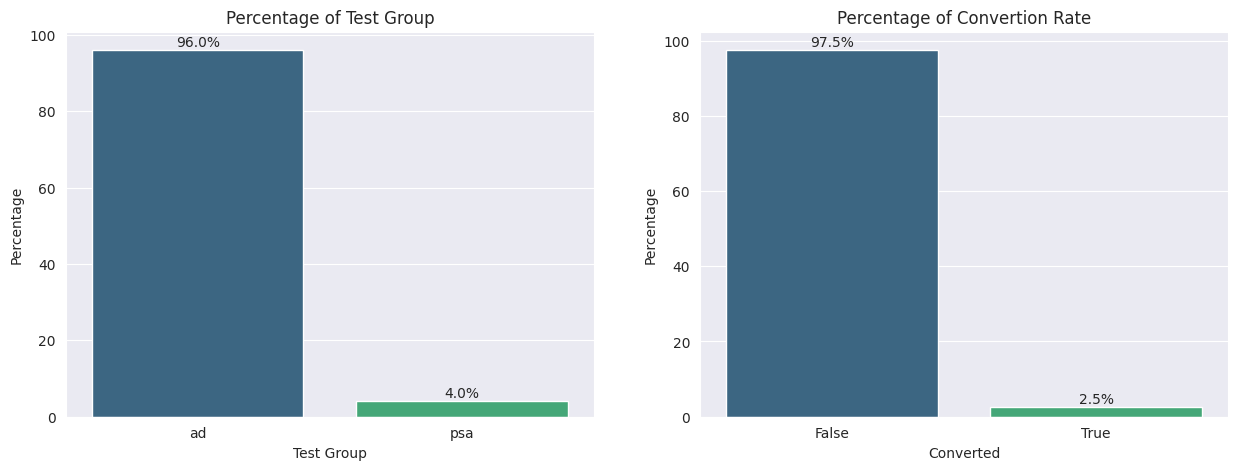

In [13]:
test_group_counts = df1['test_group'].value_counts(normalize=True) * 100
converted_counts = df1['converted'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

# Plot for 'test_group'
sns.barplot(x=test_group_counts.index, y=test_group_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Percentage of Test Group')
axes[0].set_xlabel('Test Group')
axes[0].set_ylabel('Percentage')
for i, value in enumerate(test_group_counts.values):
    axes[0].text(i, value + 1, f'{value:.1f}%', ha='center')

# Plot for 'converted'
sns.barplot(x=converted_counts.index, y=converted_counts.values, ax=axes[1], palette='viridis')
axes[1].set_title('Percentage of Convertion Rate')
axes[1].set_xlabel('Converted')
axes[1].set_ylabel('Percentage')
for i, value in enumerate(converted_counts.values):
    axes[1].text(i, value + 1, f'{value:.1f}%', ha='center');

- The `majority` of people are exposed to `ad` (the experimental group), while a `smaller` portion is exposed to `psa` (the control group).
- The majority of people don't buy the product.

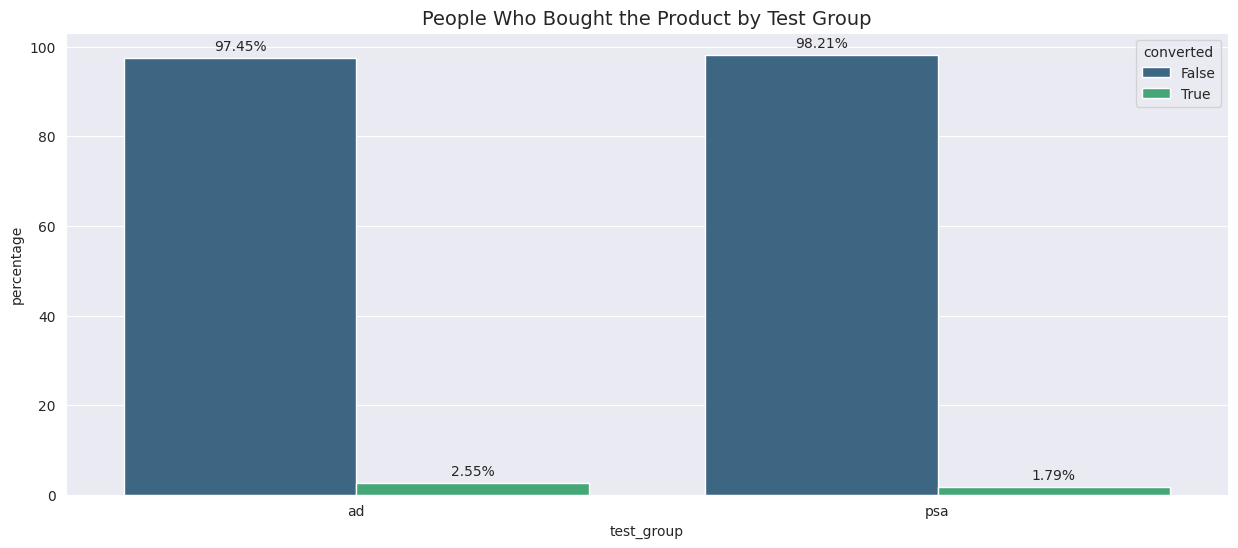

In [14]:
converted_by_test_group = df1.groupby(['test_group', 'converted']).size().reset_index(name='counts')
converted_by_test_group['percentage'] = (
    converted_by_test_group['counts'] / converted_by_test_group.groupby('test_group')['counts'].transform('sum') * 100
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='test_group', y='percentage', hue='converted', data=converted_by_test_group, palette='viridis', ax=ax)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 1,
            f'{height:.2f}%',
            ha='center',
            va='bottom'
        )

ax.set_title('People Who Bought the Product by Test Group', fontsize=14);

The majority of users saw the ads compared to those who saw the psa, but only a few of them purchased the product.

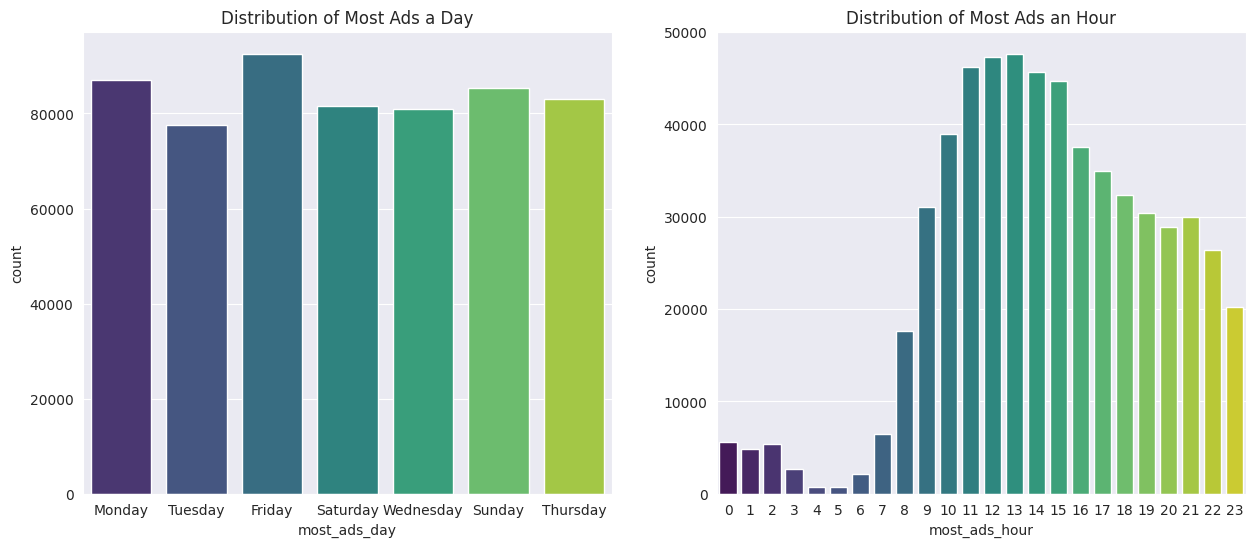

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  

# Plot for 'most_ads_day'
sns.countplot(data=df1, x="most_ads_day", ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Most Ads a Day')

# Plot for 'most_ads_hour'
sns.countplot(data=df1, x="most_ads_hour", ax=axes[1], palette='viridis')
axes[1].set_title('Distribution of Most Ads an Hour');

- The most ads seen by a user occurred on Friday.
- Between 11AM and 3PM, users saw the most ads.

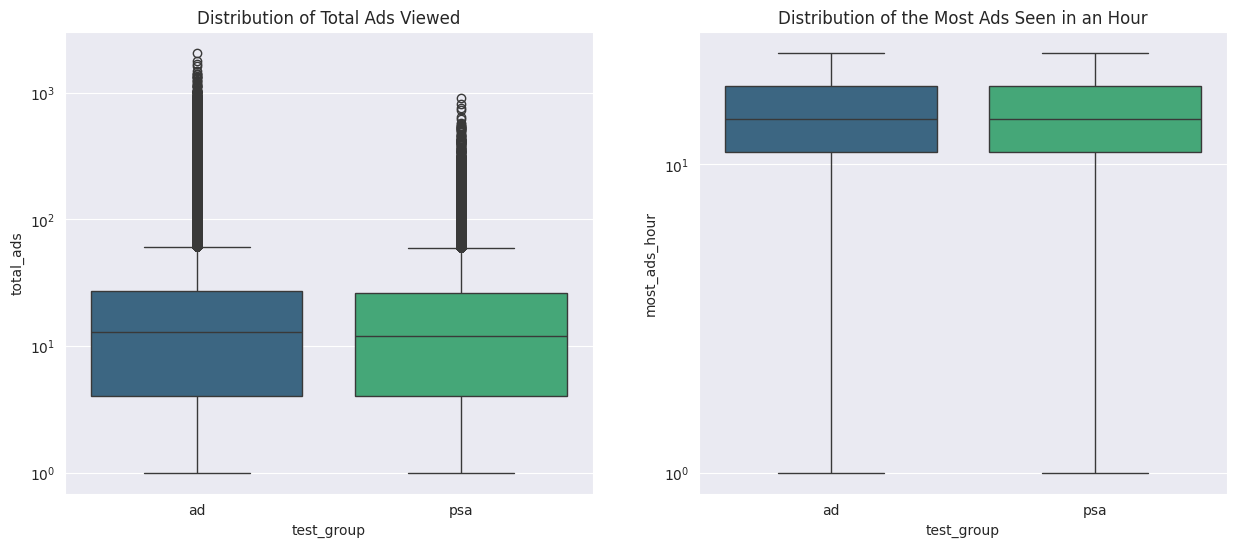

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  

# Distribution of 'total_ads' as a box plot
sns.boxplot(ax=axes[0], x='test_group', y='total_ads', data=df1, palette='viridis')
axes[0].set_title('Distribution of Total Ads Viewed')
axes[0].set_yscale('log')

# Analysis of most_ads_hour by test_group
sns.boxplot(ax=axes[1], x='test_group', y='most_ads_hour', data=df1, palette='viridis')
axes[1].set_title('Distribution of the Most Ads Seen in an Hour')
axes[1].set_yscale('log')

The `total_ads` variable has outliers in each group, as indicated by the descriptive statistics.

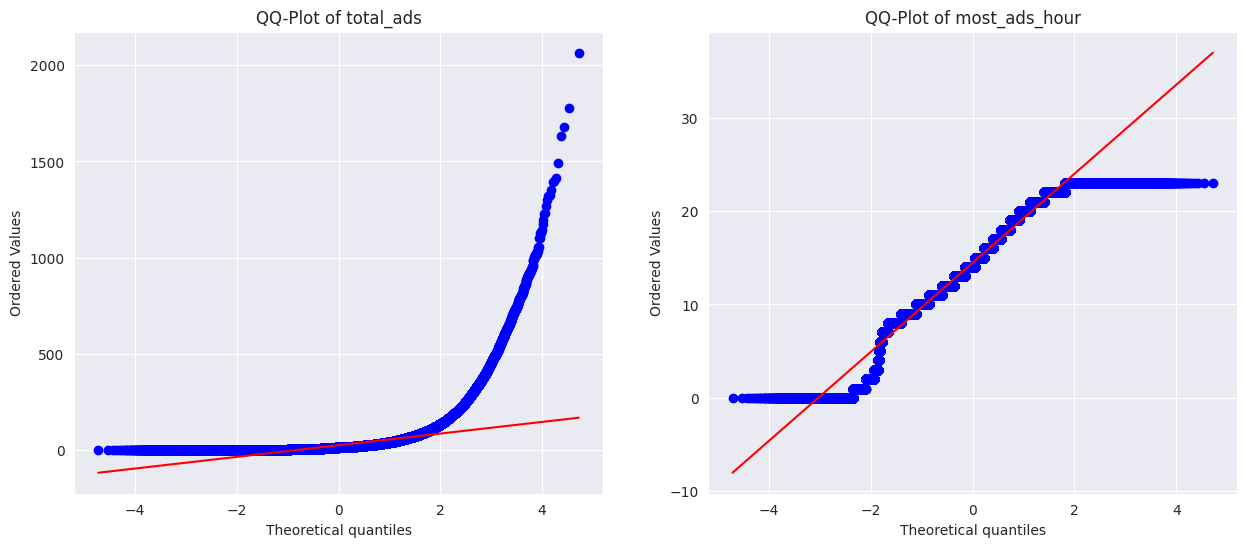

In [17]:
# Create QQ-plot for 'total_ads' and 'most_ads_hour' variables
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
stats.probplot(df1["total_ads"], dist="norm", plot=plt)
plt.title('QQ-Plot of total_ads')

# Step 2: Create QQ-plot for most_ads_hour variable
plt.subplot(1, 2, 2)
stats.probplot(df1["most_ads_hour"], dist="norm", plot=plt)
plt.title('QQ-Plot of most_ads_hour');

The Two variables `total_ads` and `most_ads_hour` are not normally distributed.

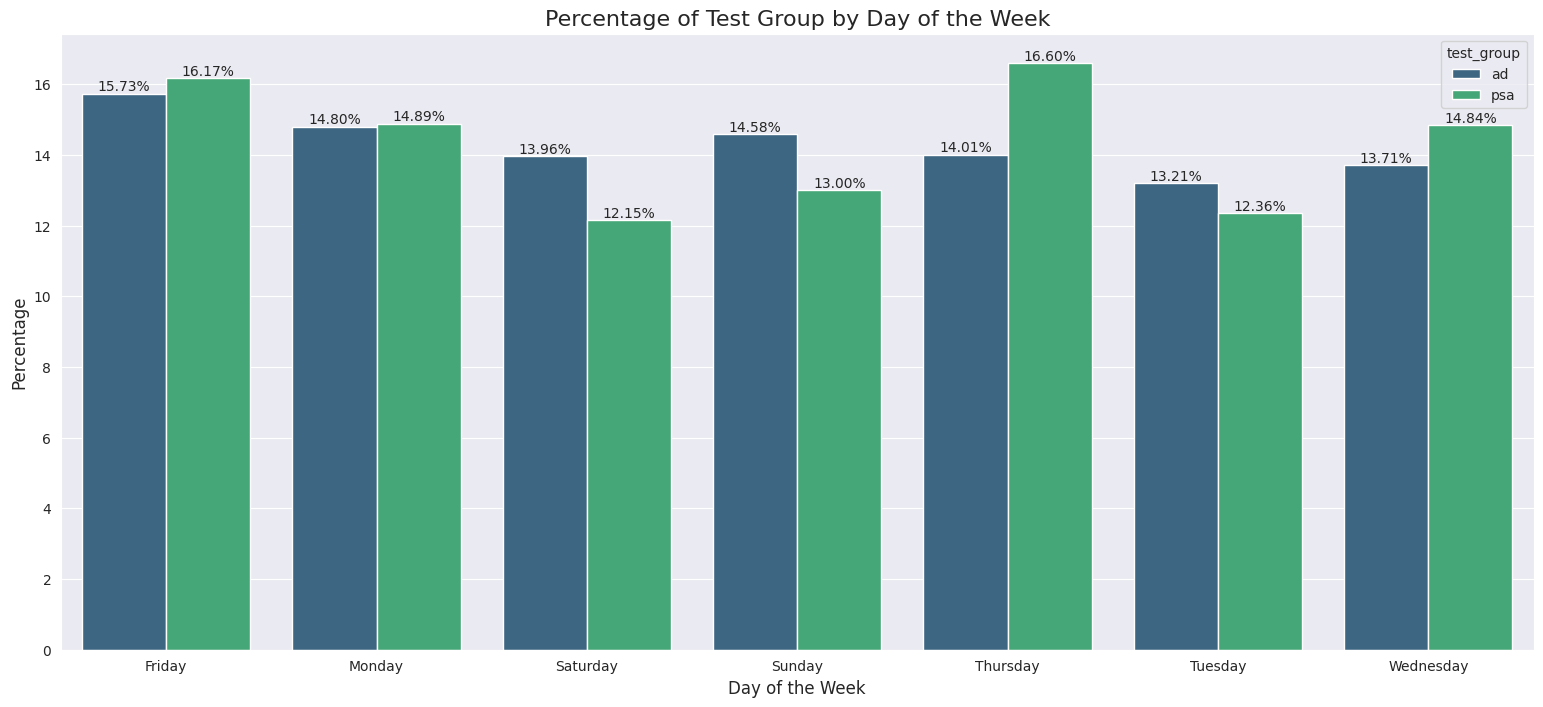

In [18]:
# Grouping the data to get percentages
grouped_data = df1.groupby(['test_group', 'most_ads_day']).size().reset_index(name='counts')

# Calculating the percentage
grouped_data['percentage'] = grouped_data['counts'] / grouped_data.groupby(['test_group'])['counts'].transform('sum') * 100

# Create the plot
plt.figure(figsize=(19, 8))
ax = sns.barplot(x='most_ads_day', y='percentage', hue='test_group', data=grouped_data, palette='viridis')

# Annotating the bars with the percentages
for p in ax.patches:
    percentage = p.get_height()
    if percentage > 0:
        ax.annotate(f'{percentage:.2f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)

# Customizing the plot
ax.set_title('Percentage of Test Group by Day of the Week', fontsize=16)
ax.set_xlabel('Day of the Week', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12);

### Understand, Evaluate, and Compare the Impact of Outliers to Make Data-Driven Decisions

In [19]:
# Create groups
experimental_group = df1[df1['test_group'] == 'ad']
control_group = df1[df1['test_group'] == 'psa']

In [20]:
# ----- Evaluate the Impact of Outliers on the Target Variable -----
print("For Experimental Group:\n")
# Conversion rates for outliers vs non-outliers
q1 = experimental_group['total_ads'].quantile(0.25)
q3 = experimental_group['total_ads'].quantile(0.75)
iqr = q3 - q1

# Define outlier threshold
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = experimental_group[experimental_group['total_ads'] > upper_bound]
non_outliers = experimental_group[experimental_group['total_ads'] <= upper_bound]

# Conversion rates
outlier_conversion_rate = outliers['converted'].mean()
non_outlier_conversion_rate = non_outliers['converted'].mean()

print(f"Outlier Conversion Rate: {outlier_conversion_rate * 100:.2f}%")
print(f"Non-Outlier Conversion Rate: {non_outlier_conversion_rate * 100:.2f}%\n")

# ----- Compare Statistical Measures -----

# Mean comparison
overall_mean = experimental_group['converted'].mean()
outlier_mean = outliers['converted'].mean()
non_outlier_mean = non_outliers['converted'].mean()

print(f"Overall Conversion Mean: {overall_mean * 100:.2f}%")
print(f"Outlier Conversion Mean: {outlier_mean * 100:.2f}%")
print(f"Non-Outlier Conversion Mean: {non_outlier_mean * 100:.2f}%\n")

# ----- Evaluate Practical Relevance -----

# Total conversions from outliers
total_conversions_outliers = outliers['converted'].sum()
total_conversions = experimental_group['converted'].sum()

contribution_from_outliers = (total_conversions_outliers / total_conversions) * 100

print(f"Outliers Contribution to Total Conversions: {contribution_from_outliers:.2f}%")


For Experimental Group:

Outlier Conversion Rate: 15.11%
Non-Outlier Conversion Rate: 1.34%

Overall Conversion Mean: 2.55%
Outlier Conversion Mean: 15.11%
Non-Outlier Conversion Mean: 1.34%

Outliers Contribution to Total Conversions: 52.24%


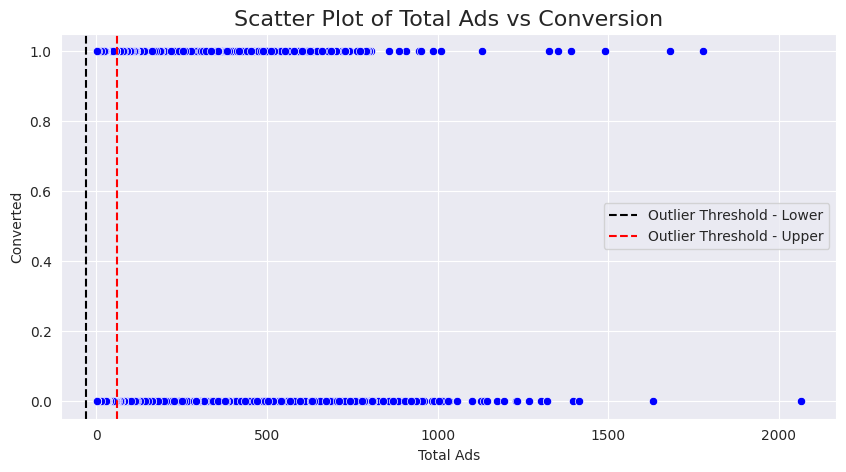

In [21]:
# ----- Visualize Outliers and Their Impact -----
plt.figure(figsize=(10, 5))
sns.scatterplot(data=experimental_group, x='total_ads', y='converted', color='blue')
plt.axvline(lower_bound, color='black', linestyle='--', label='Outlier Threshold - Lower')
plt.axvline(upper_bound, color='red', linestyle='--', label='Outlier Threshold - Upper')
plt.title("Scatter Plot of Total Ads vs Conversion", fontsize=16)
plt.xlabel("Total Ads")
plt.ylabel("Converted")
plt.legend();

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# ----- Compare Advanced Modeling Techniques -----

# Features and target with outliers
X = experimental_group[['total_ads']]  
y = experimental_group['converted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a robust model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC Score with Outliers: {auc_score:.4f}\n")

# ----- Perform Sensitivity Analysis -----

# Remove outliers and compare results
X_no_outliers = non_outliers[['total_ads']]
y_no_outliers = non_outliers['converted']

# Train-test split without outliers
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(X_no_outliers, y_no_outliers, test_size=0.3, random_state=42)

# Train model without outliers
model_no_outliers = RandomForestClassifier(random_state=42)
model_no_outliers.fit(X_train_no_out, y_train_no_out)

# Predict and evaluate without outliers
y_pred_proba_no_out = model_no_outliers.predict_proba(X_test_no_out)[:, 1]
auc_score_no_out = roc_auc_score(y_test_no_out, y_pred_proba_no_out)

print(f"ROC-AUC Score without Outliers: {auc_score_no_out:.4f}\n")

# ----- Scenario Decision -----

# Compare ROC-AUC scores
print(f"Improvement in ROC-AUC by removing outliers: {auc_score_no_out - auc_score:.4f}\n")
if auc_score_no_out > auc_score:
    print("Outliers negatively impact the model. Consider removing them.")
else:
    print("Outliers add valuable information. Keep them!")


ROC-AUC Score with Outliers: 0.8456

ROC-AUC Score without Outliers: 0.7990

Improvement in ROC-AUC by removing outliers: -0.0465

Outliers add valuable information. Keep them!


# Data Preprocessing

In [23]:
df2 = df.copy()

In [24]:
# Convert 'converted' to integer
df2['converted'] = df2['converted'].astype(int)
df2['converted'].value_counts()

converted
0    573258
1     14843
Name: count, dtype: int64

In [25]:
df2['test_group_int'] = df2['test_group'].map({'ad': 0, 'psa': 1})
df2['test_group_int'].value_counts()

test_group_int
0    564577
1     23524
Name: count, dtype: int64

# A/B Testing

**Q1:** Would the campaign be successful?

**Objective:** Evaluate if exposure to ads (experimental group) increases conversions compared to psa exposure (control group).

- **Alternative Hypothesis (H0):** Conversion rates for the experimental group ("ad") are less than or equal to the control group ("psa")
- **Alternative Hypothesis (H1):** Conversion rates for the experimental group ("ad") are greater than the control group ("psa")


**Q2:** If the campaign was successful, how much of that success could be attributed to the ads?

**Objective:** Determine if the observed conversion difference is statistically significant and attributable to ad exposure rather than random chance.

- **Null Hypothesis (H0):** The observed difference in conversion rates between groups is due to random chance.
- **Alternative Hypothesis (H1):** The observed difference in conversion rates is statistically significant and attributable to ads.

In [26]:
# Compute Pearson correlation
correlation, p_value = pearsonr(df2['test_group_int'], df2['converted'])

# Display the results
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}\n")

# Interpretation
if p_value < 0.05:
    print("There is a linear relationship between 'test_group' and conversion rate.")
else:
    print("No linear relationship between 'test_group' and conversion rate.")

Pearson Correlation Coefficient: -0.009610503311394885
P-value: 1.7033052627831312e-13

There is a linear relationship between 'test_group' and conversion rate.


In [35]:
def evaluate_campaign_success(control_group, experimental_group, alpha=0.05):
    # Calculate the relative and absolute lift in conversion
    relative_lift = ((experimental_group['converted']==True).mean() - (control_group['converted']==True).mean()) / (control_group['converted']==True).mean()
    absolute_lift = (experimental_group['converted']==True).mean() - (control_group['converted']==True).mean()
    print(f"Relative Lift in conversion: {100 * relative_lift:.2f}%")
    print(f"Absolute Lift in conversion: {100 * absolute_lift:.2f}%\n")
    
    # Print Hypothesis
    print("Testing Hypothesis:\n")
    print("H0: Conversion rates for the experimental group ('ad') <= Conversion rates for control group ('psa')")
    print("H1: Conversion rates for the experimental group ('ad') > Conversion rates for control group ('psa')\n")
    
    # Sample sizes for both groups
    n_ad = len(experimental_group)
    n_psa = len(control_group)

    # Conversion rates for both groups
    p_ad = (experimental_group['converted']).mean()
    p_psa = (control_group['converted']).mean()

    # Ensure np and n(1-p) are greater than 5 for both groups
    def check_z_test_assumptions(n, p):
        return n * p >= 5 and n * (1 - p) >= 5

    # Check for both experimental and control groups
    ad_assumption_met = check_z_test_assumptions(n_ad, p_ad)
    psa_assumption_met = check_z_test_assumptions(n_psa, p_psa)

    if ad_assumption_met and psa_assumption_met:
        print("Assumptions for the Z-test are met for both groups.\n")
    
        # Calculate the number of successes and the number of trials in both groups
        successes_converted = [(experimental_group['converted']==True).sum(), (control_group['converted']==True).sum()]
        n_obs_converted = [n_ad, n_psa]

        # Perform a one-tailed Z-test for proportions
        z_stat_converted, p_val_converted = proportions_ztest(successes_converted, n_obs_converted, alternative='larger')

        # Confidence interval for the difference in proportions
        count1, nobs1 = successes_converted[0], n_obs_converted[0]
        count2, nobs2 = successes_converted[1], n_obs_converted[1]
        ci_lower, ci_upper = confint_proportions_2indep(count1, nobs1, count2, nobs2, compare='diff', alpha=alpha)
        
        # Print results
        print(f"Z-statistic for conversion rate: {z_stat_converted:.5f}")
        print(f"P-value for conversion rate: {p_val_converted:.5f}\n")
        print(f"{1 - alpha}% Confidence Interval for difference in conversion rates: ({ci_lower*100:.2f}%, {ci_upper*100:.2f}%)\n")

        # Perform power analysis
        effect_size = count1 - count2 # 2 * (np.arcsin(np.sqrt(count1/nobs1)) - np.arcsin(np.sqrt(count2/nobs2))) 
        power_analysis = NormalIndPower()
        power = power_analysis.solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=nobs2/nobs1, alternative='larger')
        print(f"Power of the test: {100 * power:.2f}%\n")
        
        # Determine statistical significance
        if p_val_converted < alpha:
            print("Reject H0: The conversion rate has significantly increased due to ads exposure.\n\nWould the campaign be successful? Yes!")
        else:
            print("Fail to reject H0: There is no significant increase in the conversion rate due to ads exposure.\n\nWould the campaign be successful? No!")
    else:
        print("Assumptions for the Z-test are not met. Consider using an alternative test.")


In [36]:
# Create groups
experimental_group = df2[df2['test_group'] == 'ad']
control_group = df2[df2['test_group'] == 'psa']

evaluate_campaign_success(control_group, experimental_group, alpha=0.02)

Relative Lift in conversion: 43.09%
Absolute Lift in conversion: 0.77%

Testing Hypothesis:

H0: Conversion rates for the experimental group ('ad') <= Conversion rates for control group ('psa')
H1: Conversion rates for the experimental group ('ad') > Conversion rates for control group ('psa')

Assumptions for the Z-test are met for both groups.

Z-statistic for conversion rate: 7.37008
P-value for conversion rate: 0.00000

0.98% Confidence Interval for difference in conversion rates: (0.55%, 0.97%)

Power of the test: 100.00%

Reject H0: The conversion rate has significantly increased due to ads exposure.

Would the campaign be successful? Yes!


- Ads significantly increased conversions compared to the PSA group.
- The 43.09% lift shows a strong improvement in conversions due to ads.
- The 100% test power ensures reliable results and a minimal chance of Type II error (the probability of failing to reject the null hypothesis when it is false).

In [29]:
def ab_testing(data, group_col, target_col, alpha=0.05):
    """
    Perform A/B Testing on a given dataframe and calculate statistical power.

    Parameters:
    - data: DataFrame containing the data.
    - group_col: Column name that specifies the group ('ad', 'psa').
    - target_col: Column name of the target variable to analyze.
    - alpha: Significance level, default is 0.05.

    Returns:
    - A dictionary summarizing the test results, including power.
    """
    # Print Hypothesis
    print("Testing Hypothesis:\n")
    print("H0: The observed difference in conversion rates between groups is due to random chance.")
    print("H1: The observed difference in conversion rates is statistically significant and attributable to ads.\n")

    try:
        # Check if the target_col is either 'converted', 'total_ads', or 'most_ads_hour'
        if target_col not in ['converted', 'total_ads', 'most_ads_hour']:
            raise ValueError("Choose 'converted' or 'total_ads' or 'most_ads_hour' as target feature!")
        
        # Split A/B groups
        ad_group = data[data[group_col] == "ad"][target_col]
        psa_group = data[data[group_col] == "psa"][target_col]

        # Assumption: Normality
        p_val_ad = shapiro(ad_group)[1]  # p-value for ad group
        p_val_psa = shapiro(psa_group)[1]  # p-value for psa group

        # Check assumptions and choose the appropriate test
        if p_val_ad > 0.05 and p_val_psa > 0.05:  
            # Assumption: Homogeneity of variances
            levene_stat, levene_p = levene(ad_group, psa_group)

            # Homogeneity
            if levene_p > 0.5:  
                test_stat, p_value = ttest_ind(ad_group, psa_group, equal_var=True)
                test_type = "Parametric (T-Test)"
            else:  
                # Heterogeneous 
                test_stat, p_value = ttest_ind(ad_group, psa_group, equal_var=False)
                test_type = "Parametric (Welch's T-Test)"
        else: 
            # Non-Parametric Test 
            # Non-Normal Distribution
            test_stat, p_value = mannwhitneyu(ad_group, psa_group)
            test_type = "Non-Parametric (Mann-Whitney U Test)"

        # Calculate effect size (Cohen's d for T-test)
        if test_type in ["Parametric (T-Test)", "Parametric (Welch's T-Test)"]:
            mean_diff = ad_group.mean() - psa_group.mean()
            pooled_std = ((ad_group.std() ** 2 + psa_group.std() ** 2) / 2) ** 0.5
            effect_size = mean_diff / pooled_std
        else:
            effect_size = None  # Effect size for non-parametric tests is not easily calculated

        # Power calculation (for T-test)
        if test_type in ["Parametric (T-Test)", "Parametric (Welch's T-Test)"]:
            power_analysis = TTestIndPower()
            n1, n2 = len(ad_group), len(psa_group)
            power = power_analysis.solve_power(effect_size=effect_size, nobs1=n1, alpha=alpha)
        else:
            power = None  # Power calculation is not as straightforward for non-parametric tests

        # Summarize results
        result = {
            "Test Type": test_type,
            "p-value": p_value,
            "Decision": "Reject H0" if p_value < alpha else "Fail to Reject H0",
            "Power": power,
            "Effect Size": effect_size
        }
        
        if target_col == "converted":
            result["Conclusion"] = "We have sufficient evidence to say that the conversion rate is statistically significant and can be attributed to ads." if p_value < alpha else "We have insufficient evidence to claim that the conversion rate is statistically significant.\nIt could be due to random chance"
        elif target_col == "total_ads":
            result["Conclusion"] = "We have sufficient evidence to say that the number of ads is statistically significant." if p_value < alpha else "We have insufficient evidence to claim that number of ads is statistically significant.\nIt could be due to random chance"
        elif target_col == "most_ads_hour":
            result["Conclusion"] = "We have sufficient evidence to say that the most ads hour is statistically significant." if p_value < alpha else "We have insufficient evidence to claim that the most ads hour is statistically significant.\nIt could be due to random chance"

        # Include Homogeneity information if parametric tests were applied
        if "Parametric (T-Test)" in test_type or "Parametric (Welch's T-Test)" in test_type:
            result["Homogeneity"] = ["Yes" if levene_p > 0.5 else "No"]

        return result

    except Exception as e:
        # If an error occurs, print the error message
        print(f"Error occurred: {e}")
        return None


In [30]:
result = ab_testing(df2, group_col='test_group', target_col='converted')
result

Testing Hypothesis:

H0: The observed difference in conversion rates between groups is due to random chance.
H1: The observed difference in conversion rates is statistically significant and attributable to ads.



{'Test Type': 'Non-Parametric (Mann-Whitney U Test)',
 'p-value': 1.7053617930171878e-13,
 'Decision': 'Reject H0',
 'Power': None,
 'Effect Size': None,
 'Conclusion': 'We have sufficient evidence to say that the conversion rate is statistically significant and can be attributed to ads.'}

In [31]:
result = ab_testing(df2, group_col='test_group', target_col='total_ads')
result

Testing Hypothesis:

H0: The observed difference in conversion rates between groups is due to random chance.
H1: The observed difference in conversion rates is statistically significant and attributable to ads.



{'Test Type': 'Non-Parametric (Mann-Whitney U Test)',
 'p-value': 4.6909108547205694e-11,
 'Decision': 'Reject H0',
 'Power': None,
 'Effect Size': None,
 'Conclusion': 'We have sufficient evidence to say that the number of ads is statistically significant.'}

In [32]:
result = ab_testing(df2, group_col='test_group', target_col='most_ads_hour')
result

Testing Hypothesis:

H0: The observed difference in conversion rates between groups is due to random chance.
H1: The observed difference in conversion rates is statistically significant and attributable to ads.



{'Test Type': 'Non-Parametric (Mann-Whitney U Test)',
 'p-value': 8.413493820381716e-09,
 'Decision': 'Reject H0',
 'Power': None,
 'Effect Size': None,
 'Conclusion': 'We have sufficient evidence to say that the most ads hour is statistically significant.'}

All P-values are extremely small (<0.05), rejecting the null hypothesis in all cases. This indicates that:
- The observed conversion difference is statistically significant and can be confidently attributed to ad exposure.
- The number of ads and the timing of ad exposure (most ads hour) also show significant effects, reinforcing the campaign's efficacy.

# Conclusion

- The campaign is a success, with ads significantly boosting conversion rates compared to PSAs.
- The increase in conversions is proven to result from the ads, not random chance.
- A 43.09% relative lift highlights the campaign's strong impact.

# Recommendations

- **Scale Up:** Expand the campaign to reach more people, focusing on peak impact times.
- **Refine Ads:** Analyze top-performing ads to improve content and design.
- **Segment Analysis:** Study the impact of ads on different groups to tailor strategies.
- **Track Performance:** Continuously monitor results and test new ad approaches.
- **Shift Budget:** Invest more in ads over PSAs to maximize conversion gains.